# Challenges in Transfer Learning in NLP: sentence representation example

## Introduction

In this Meetup we are going to experiment different sentences representation related with Transfer Learning in NLP models for the task of **Semantic Textual Similarity** (STS). 

After pre-processing the dataset, we obtain each phrase token list and later we use different models to represent final sentence: pre-trained word embedding from FastText and Universal Sentence Encoder.

Verify you have installed all this packages (Python 3 version).

In [1]:
import nltk
import codecs
import numpy as np
import matplotlib
import seaborn
import scipy
import tensorflow
import tensorflow_hub

import itertools
import io

W0514 20:33:26.779420 19648 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Dataset preprocessing 

From STSBenchmark CSVs this library extract the **test phrases** and tokenize and preprocess the phrases (lowercase, strange characters removed, etc.). For us, it is enought to load test dataset, to start the experiment fastly!

In [2]:
from corpus import STS_Corpus
corpus = STS_Corpus()

In [3]:
# terms with repetitions
terms = corpus.words()
# vocabulary
vocabulary = set(terms)
print(len(vocabulary))

4063


In [4]:
# sentences token list pairs and annotated similarity (gold standard) from test STS Benchmark
sentences, annotated_similarities = corpus.sts_parts()
print(len(sentences))

# get strings without pairs
sentences_str = [[' '.join(item[0]), ' '.join(item[1])] for item in sentences]
#print(sentences_str)
sentences_plain = list(itertools.chain(*sentences_str))
print(sentences_plain[:8])

1379
['a girl is styling her hair', 'a girl is brushing her hair', 'a group of men play soccer on the beach', 'a group of boys are playing soccer on the beach', 'one woman is measuring another woman s ankle', 'a woman measures another woman s ankle', 'a man is cutting up a cucumber', 'a man is slicing a cucumber']


## Working with pre-trained word embedding: FastText example

We use the pre-trained with **FastText**, we select and load the necessary vectors from 1 million word vectors trained on Wikipedia 2017. 

In [5]:
def load_vectors(selected_tokens, fname='wiki-news-300d-1M.vec'):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    vocabulary = []
    for line in fin:
        tokens = line.rstrip().split(' ')
        vocabulary.append(tokens[0])
        if tokens[0] in selected_tokens:
            data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data, vocabulary

In [6]:
# attention! be patient...
fast_text_wv, fast_text_vocabulary = load_vectors(vocabulary)
len(fast_text_wv)

3885

In [7]:
# review word vectors with an example
vector_size = len(list(fast_text_wv['word']))
print(fast_text_wv['word'][:15])
print(vector_size)

[-0.0078  0.0075  0.0203  0.0991  0.0315 -0.0284  0.144   0.1352  0.0612
  0.0649 -0.0026 -0.0589  0.0478 -0.0337 -0.0233]
300


How many terms are embedded in the pre-trained word embedding? What percent of 'unknown words' do we have?

In [8]:
common_terms = len(vocabulary.intersection(fast_text_wv.keys()))
unknown_words = vocabulary.difference(fast_text_wv.keys())
print(unknown_words)

{'dominick', 'spx', 'schofield', 'desailly', 'mier', 'skagit', 'loral', 'magaluf', 'sayliyah', 'dennehy', 'bucklew', 'gox', 'yellen', 'alyokhina', 'buymusic', 'safeway', 'ŕä', '‚äėpariah', 'nlc', 'nearearth', 'state‚äô', 'kernan', 'tanase', 'mursi', 'goodrich', 'junya', 'techheavy', 'heatley', 'mukhlas', 'musharraf', 'lowyield', 'odette', 'biogen', 'bahraini', 'brendsel', 'qarase', 'rehnquist', 'worldcom', 'ginsburg', 'mediaq', 'expremier', '_', 'utor', 'cmie', 'midtexas', 'yearago', 'ibc', 'tiburtina', 'anadarko', 'seifert', 'reagans', 'lingle', 'lorna', 'miodrag', 'dragan', 'pervez', 'rouhani', 'mandalay', 'bremer', 'citicorp', 'alcoa', 'sunncomm', 'klarman', 'vasant', 'odonnell', 'techlaced', 'staterun', 'asiana', 'lafferty', 'supoyo', 'nishikori', 'veneman', 'barbini', 'threeday', 'plmo', 'ankeet', 'popovich', 'colvin', 'webvpn', 'souter', 'twostate', 'schiphol', 'geraldine', 'comstock', 'gromer', 'ebbers', 'mediamax', 'alqaida', 'redford', '£m', 'pcts', 'cii', 'eddington', 'dhawan

In [9]:
print(100 * (len(vocabulary) - common_terms) / len(vocabulary))

4.380999261629338


### Lexical similarity and analogies

Let's calculate cosine similarity between words, based on cosine distance between word vectors.

In [10]:
def cosine_similarity(first_wv, second_wv):
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cosine.html
    return -scipy.spatial.distance.cosine(first_wv, second_wv)+1

In [11]:
print(cosine_similarity(fast_text_wv['girl'], fast_text_wv['woman']))
print(cosine_similarity(fast_text_wv['boy'], fast_text_wv['man']))
print(cosine_similarity(fast_text_wv['boy'], fast_text_wv['girl']))
print(cosine_similarity(fast_text_wv['man'], fast_text_wv['woman']))

0.7440819556508348
0.6806782750347294
0.8618076966028508
0.8164521901114025


Test analogies and lineal relations captured by word embedding trained with FastText.

In [12]:
# “A is to B what C is to X” using simple arithmetic. This is generally simplified as “King — Man + Woman = Queen.”
similar_wv_woman = fast_text_wv['man'] - fast_text_wv['boy'] + fast_text_wv['girl']

In [13]:
def similar_words(focus_vector, word_vectors, num_similar=5):
    similarities = {}
    for word, vector in word_vectors.items():
        similarities[word] = cosine_similarity(focus_vector, vector)
    similarities_sorted = sorted(similarities, key=similarities.get, reverse=True)
    return similarities_sorted[:num_similar]

In [14]:
print(cosine_similarity(similar_wv_woman, fast_text_wv['woman']))
print(similar_words(similar_wv_woman, fast_text_wv))

0.8453537898967799
['man', 'woman', 'girl', 'lady', 'men']


In [15]:
print(cosine_similarity(similar_wv_woman, fast_text_wv['man']))
print(similar_words(fast_text_wv['man'], fast_text_wv))
print(similar_words(fast_text_wv['boy'], fast_text_wv))

0.8490334599218811
['man', 'woman', 'guy', 'men', 'person']
['boy', 'girl', 'boys', 'kid', 'teenager']


Is there any bias?

In [16]:
print(cosine_similarity(fast_text_wv['man'], fast_text_wv['house']))
print(cosine_similarity(fast_text_wv['woman'], fast_text_wv['house']))

0.4767117868647288
0.4848852537394086


### Word embedding visualization

Let's do a cualitative intrinsic evaluation!

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scipy.spatial.distance as scpdist

def tsne_plot(labels, tokens):
    x,y = [],[]
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    for value in new_values:
        x.append(value[0])
        y.append(value[1])        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

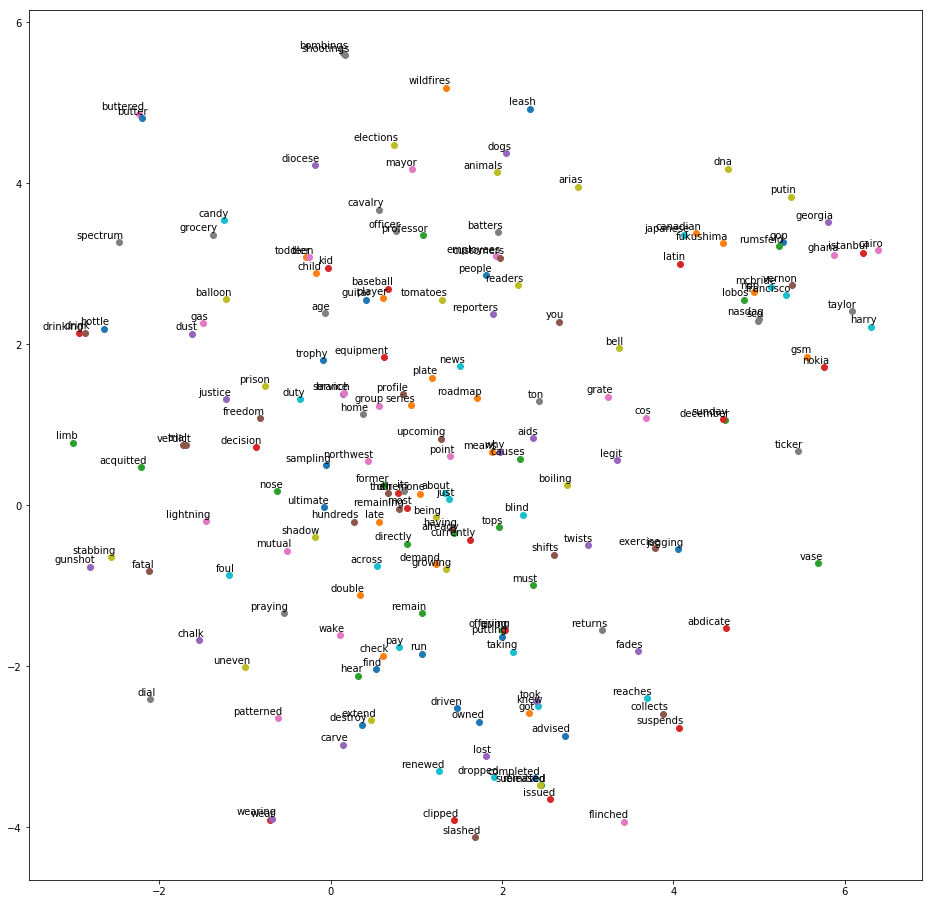

In [18]:
tsne_plot(list(fast_text_wv.keys())[:180], list(fast_text_wv.values())[:180])

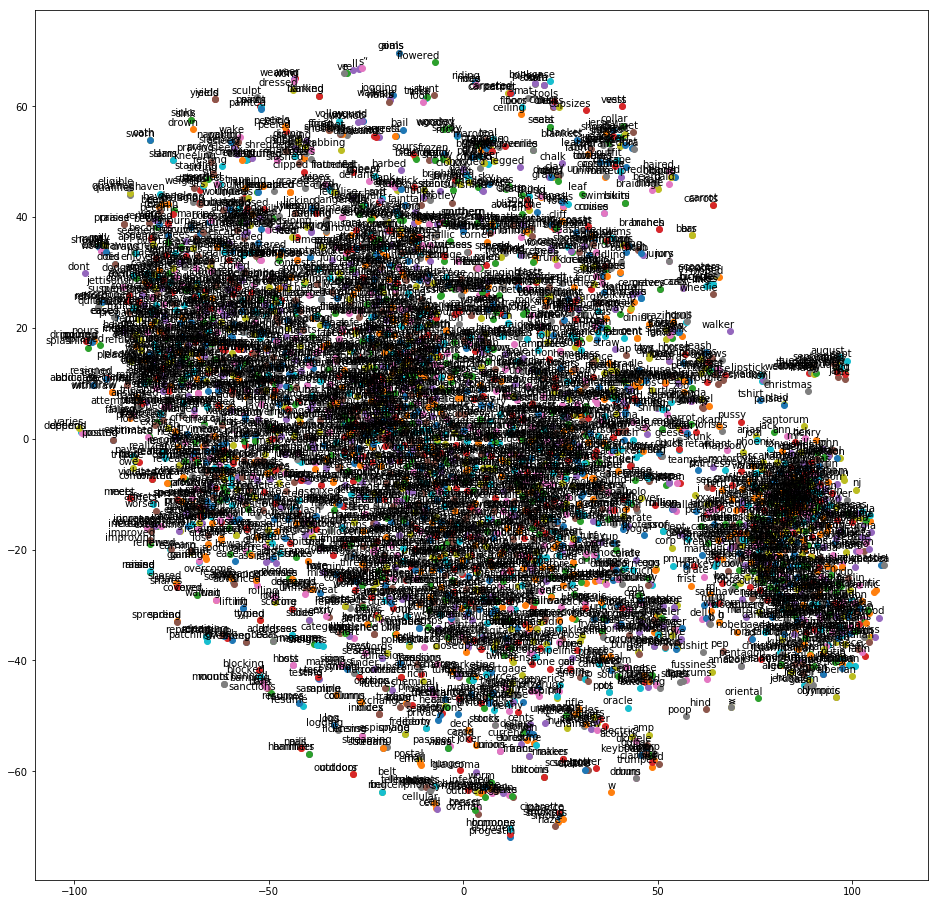

In [19]:
# be patient...
tsne_plot(list(fast_text_wv.keys()), list(fast_text_wv.values()))

## Sentence representations

### Averaged word embedding baseline

Like SemEval-2017 task 1 proposal, we encode the phrase by averaging its word vectors.

In [19]:
def sentence_encoder(token_list, word_vectors):
    sentence_list = []
    for token in token_list:
        if token in word_vectors.keys():
            sentence_list.append(word_vectors[token])
    sentence_array = np.array(sentence_list)
    return np.mean(sentence_array, axis=0)

In [20]:
sentence_encoder(['a', 'girl', 'is', 'styling', 'her', 'hair'], fast_text_wv)[:15]

array([ 0.00375   , -0.00013333, -0.05166667, -0.0492    , -0.04418333,
        0.0116    , -0.0088    ,  0.01601667,  0.01983333,  0.07398333,
        0.0198    , -0.04636667,  0.09646667,  0.05405   , -0.02993333])

In [21]:
sentences_representation = [[sentence_encoder(sent1, fast_text_wv), sentence_encoder(sent2, fast_text_wv)] \
                                      for [sent1, sent2] in sentences]

#### Review representation

Is this representation strong enough?

In [22]:
example_sentence = ['a', 'man', 'with', 'a', 'hard', 'hat', 'is', 'dancing']
negative_example = ['a', 'man', 'with', 'a', 'hard', 'hat', 'is', 'not', 'dancing']
paraphrase_example = ['a', 'man', 'wearing', 'a', 'hat', 'is', 'dancing']

In [23]:
print(cosine_similarity(sentence_encoder(example_sentence, fast_text_wv), sentence_encoder(negative_example, fast_text_wv)))
print(cosine_similarity(sentence_encoder(example_sentence, fast_text_wv), sentence_encoder(paraphrase_example, fast_text_wv)))

0.9945667636331156
0.962200616329868


#### Sentences similarity and comparison with gold standard

In [24]:
sentences_similarities = [cosine_similarity(s1_vector, s2_vector) for [s1_vector, s2_vector] in sentences_representation]
print(max(sentences_similarities))
print(min(sentences_similarities))

1.0
0.4044959452248953


In [25]:
final_result = 100* np.corrcoef(np.array(sentences_similarities), np.array(annotated_similarities))[0][1]
print(final_result)

48.92616729474983


### Universal Sentence Encoder

With the next module, we initialize earlier the Universal Sentence Encoder from Google Tensorflow Hub.

In [26]:
from use import *
models = [('univ-sent-enc-transformer','Univ Sent Enc Trans ENG'), 
         ('univ-sent-enc-dan', 'Univ Sent Enc DAN ENG')]

In [27]:
example_sentence = 'a man with a hard hat is dancing'
negative_example = 'a man with a hard hat is not dancing'
paraphrase_example = 'a man wearing a hat is dancing'

In [28]:
sentences_examples_use = [example_sentence, negative_example, paraphrase_example]
sentence_encoder_transf, model_result_transf = test_execution(models[0][0], sentences_examples_use)
test_model(models[0][0], models[0][1], sentences_examples_use)

Instructions for updating:
Colocations handled automatically by placer.


W0514 20:38:47.161814 19648 deprecation.py:323] From c:\users\l.olmos.camarena\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 20:38:48.740724 19648 saver.py:1483] Saver not created because there are no variables in the graph to restore


Execution time univ-sent-enc-transformer: 6.746073484420776
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 20:38:55.615450 19648 saver.py:1483] Saver not created because there are no variables in the graph to restore


Execution time univ-sent-enc-transformer: 9.346701383590698


<Figure size 864x432 with 0 Axes>

In [29]:
print(cosine_similarity(model_result_transf[0], model_result_transf[1]))
print(cosine_similarity(model_result_transf[0], model_result_transf[2]))

0.8056762218475342
0.9239606261253357


#### Run with whole dataset

In [32]:
#be patient...
sentence_encoder_transf, model_result_transf = test_execution(models[0][0], sentences_plain)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 19:56:20.708950 18632 saver.py:1483] Saver not created because there are no variables in the graph to restore


Execution time univ-sent-enc-transformer: 40.15134143829346


In [33]:
#be patient...
sentence_encoder_dan, model_result_dan = test_execution(models[1][0], sentences_plain)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 19:57:04.611681 18632 saver.py:1483] Saver not created because there are no variables in the graph to restore


Execution time univ-sent-enc-dan: 28.365777254104614


#### Sentences similarity and comparison with gold standard

In [34]:
cosine_univ_sent_transf = []
for i in range(0, len(model_result_transf)-1):
    if i % 2 == 0:
        cosine_univ_sent_transf.append(cosine_similarity(np.array(model_result_transf[i]), np.array(model_result_transf[i+1])))

final_result_univ_enc_transf = 100* np.corrcoef(np.array(cosine_univ_sent_transf), np.array(annotated_similarities))[0][1]
print(final_result_univ_enc_transf)

74.69187313054053


In [35]:
cosine_univ_sent_dan = []
for i in range(0, len(model_result_dan)-1):
    if i % 2 == 0:
        cosine_univ_sent_dan.append(cosine_similarity(np.array(model_result_dan[i]), np.array(model_result_dan[i+1])))

final_result_univ_enc_dan = 100* np.corrcoef(np.array(cosine_univ_sent_dan), np.array(annotated_similarities))[0][1]
print(final_result_univ_enc_dan)

69.4376479013416


# References

Dataset **STSBenchmark**:     http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz

**FastText** English pre-trained word embeddings: https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

From: T. Mikolov, E. Grave, P. Bojanowski, C. Puhrsch, A. Joulin. Advances in Pre-Training Distributed Word Representations

**Universal Sentence Encoder**. Cer, D., Yang, Y., Kong, S. Y., Hua, N., Limtiaco, N., John, R. S., ... & Sung, Y. H. (2018). Universal sentence encoder. arXiv preprint arXiv:1803.11175. See in arXiv

## Further Reading

Cer, D., Diab, M., Agirre, E., Lopez-Gazpio, I., & Specia, L. (2017). Semeval-2017 task 1: Semantic textual similarity-multilingual and cross-lingual focused evaluation. arXiv preprint arXiv:1708.00055. https://arxiv.org/pdf/1708.00055.pdf

SentEval: evaluation toolkit for sentence embeddings. https://github.com/facebookresearch/SentEval

Advances in Semantic Textual Similarity. https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html